[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fadheladlansyah/Fraud_Detection/blob/master/modeling.ipynb)

# 0. Set access to drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 1. Libraries

In [0]:
import numpy as np
import pandas as pd
pd.options.display.precision = 10
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb

import time
from joblib import dump, load
import random
import itertools
from tqdm import tqdm_notebook

import os
import gc
import warnings
warnings.filterwarnings("ignore")

In [0]:
# set random seed
SEED = 42
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

# 2. Load processed data

In [17]:
folder_path = './drive/My Drive/Colab Notebooks/purwadhika/'

train_df = pd.read_csv(folder_path+'train.csv')
test_df = pd.read_csv(folder_path+'test.csv')

y_train = train_df['isFraud']
X_train = train_df.drop('isFraud', axis=1)
y_test = test_df['isFraud']
X_test = test_df.drop('isFraud', axis=1)

del train_df, test_df
display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(472432, 103)

(472432,)

(118108, 103)

(118108,)

# 3. Metrics

Generally for kind of __fraud problems__, the approach taken is __to contain all problems__ and __increase awereness__. It focus on positive condition. First, to contain all problems means to increase true positive rate (TPR), so that the company is able to cancel the transaction immediately and prevent loss. Then, to increase awareness, is the condition which the company should do further check before proceeding the transaction, the company loss is less probable in this condition.

## Confusion Matrix

To get basis idea of the classification results.

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix"',
                          cmap=plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## ROC AUC

- Have diagnostic ability to design treshold and further decision
- It is more robust to imbalance class

In [0]:
def plot_roc_auc(fpr, tpr):
    roc_auc = auc(fpr,tpr)

    plt.figure(figsize=(6,5))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

# 4. Model

Well in the sense that I don't commit the best exploration and feature engineering, still resulting large proceseed data. Simple model less probable to perform well. The other options is gradient boosted models that are more robust to this kind of conditions.

Still, I will do the simple model one using Logistic and see the performance and choose the gradient boosting model as comparison.

### Simple Logistic

parameters tuning (C, penalty, iter) using GridSearchCV to get best parameters

In [7]:
start_time = time.time()

log_reg_params = {
    'C':[0.5, 0.8, 1, 1.2],
    'penalty':['l1', 'l2', 'elasticnet'],
    'max_iter':[100, 200]
}

log_reg = LogisticRegression()
clf = GridSearchCV(log_reg, log_reg_params, cv=5)
clf.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

dump(clf, folder_path+'gridCV_log.joblib')

--- 866.9319474697113 seconds ---


['./drive/My Drive/Colab Notebooks/purwadhika/gridCV_log.joblib']

In [8]:
y_pred = clf.predict(X_train)
fpr, tpr, _ = roc_curve(y_train, clf.predict_proba(X_train)[:,1])

display(confusion_matrix(y_train, y_pred))
print('Training AUC', auc(fpr,tpr))

array([[455167,    666],
       [ 14181,   2418]])

Training AUC 0.8327334610273198


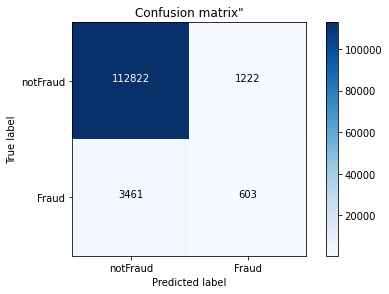

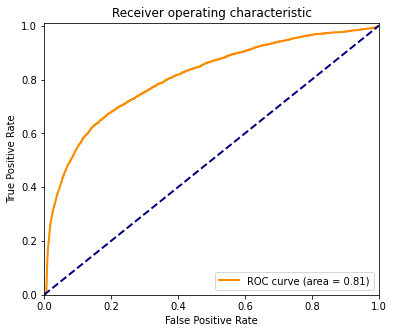

In [18]:
clf = load(folder_path+'gridCV_log.joblib') 

y_pred_test = clf.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

plot_confusion_matrix(confusion_matrix(y_test, y_pred_test), ['notFraud', 'Fraud'])
plot_roc_auc(fpr,tpr)

By seeing the confusion matrix, I wont bother to try fold strategy to optimize the performance.

## Boosted models, LGBM

Gradient boosting is a sort of best both classification and regression algorithm, in the sense that models are optimized via gradient descent on specified loss functions. But also reap the idea and  benefits of tree-based models : feature selection and interaction, scale invariance, and ability to capture (highly) non-linear feature-target relationships. These characteristics make gradient boosted models very robust to messy and heterogenous data (e.g. nullness, outliers, mix of numerics on different scales and categoricals). While LGBM is the most preferred gradient boosting models much likely because of the shortest learning time.


- Combine with StratifiedKFold to increase generalization power. StratifiedKFold matter the sample proportion for each class.
- Parameters tuning on:

  - __n_split fold__ higher, increase generalization by aggregating feature importance in each folds
  - __learning_rate__ lower, let the model converge better
  - __num_iterations__ higher or num_trees, tune with learning_rate, so that converging model do not stop learning because of number of iteration limit
  - __num_leaves__ higher, max number of leaves in one tree
  - __feature_fraction__, increase generalization by selecting part of features on each iteration (tree)

In [0]:
def makePredictions(tr_df, tt_df, target, lgb_params, NFOLDS=2):
    skfolds = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

    X,y = tr_df, target  
    P = tt_df
    predictions = np.zeros(len(tt_df))
    
    features = list(tr_df.columns)
    feature_importance_df = pd.DataFrame()
    
    for fold_, (trn_idx, val_idx) in enumerate(skfolds.split(X, y)):
        
        print('Fold:',fold_)
        start_time = time.time()

        tr_x, tr_y = X.iloc[trn_idx,:], y[trn_idx]
        vl_x, vl_y = X.iloc[val_idx,:], y[val_idx]
            
        print(len(tr_x),len(vl_x))
        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)  

        estimator = lgb.train(
            lgb_params,
            tr_data,
            valid_sets = [tr_data, vl_data],
            verbose_eval = 200,
        )

        print("--- %s seconds ---" % (time.time() - start_time))

        dump(estimator, folder_path+f'lgb_fold{fold_}.joblib')

        pp_p = estimator.predict(P)
        predictions += pp_p/NFOLDS
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = features
        fold_importance_df["importance"] = estimator.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        del tr_x, tr_y, vl_x, vl_y, tr_data, vl_data
        gc.collect()
        
    tt_df['prediction'] = predictions
    
    return tt_df, feature_importance_df

In [10]:
lgb_params = {
    'objective':'binary',
    'boosting_type':'gbdt',  #default
    'metric':'auc',
    'n_jobs':-1,  #default
    'learning_rate':0.01,  #default 0.1
    'num_leaves': 256, #default 31
    'max_depth':-1, #default
    'tree_learner':'serial',
    'feature_fraction': 0.7,  #default 1
    'subsample_freq':1, #default 0
    'subsample':0.7,  #default 1
    'num_iterations':1800, #default 100
    'max_bin':255,  #default
    'verbose':-1,
    'seed': SEED,
    'early_stopping_rounds':100,
}
  
test_df_w_pred_lgb, feat_importance_df_lgb = makePredictions(X_train, X_test, y_train, lgb_params, NFOLDS=8)

Fold: 0
413378 59054
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.956306	valid_1's auc: 0.927426
[400]	training's auc: 0.983292	valid_1's auc: 0.947476
[600]	training's auc: 0.992285	valid_1's auc: 0.956279
[800]	training's auc: 0.996082	valid_1's auc: 0.960235
[1000]	training's auc: 0.997934	valid_1's auc: 0.962657
[1200]	training's auc: 0.998911	valid_1's auc: 0.964066
[1400]	training's auc: 0.999432	valid_1's auc: 0.965043
[1600]	training's auc: 0.999732	valid_1's auc: 0.96571
[1800]	training's auc: 0.999871	valid_1's auc: 0.966249
Did not meet early stopping. Best iteration is:
[1800]	training's auc: 0.999871	valid_1's auc: 0.966249
--- 698.2026269435883 seconds ---
Fold: 1
413378 59054
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.955947	valid_1's auc: 0.926637
[400]	training's auc: 0.983372	valid_1's auc: 0.945737
[600]	training's auc: 0.992539	valid_1's auc: 0.954298
[800]	training's auc: 0.996174

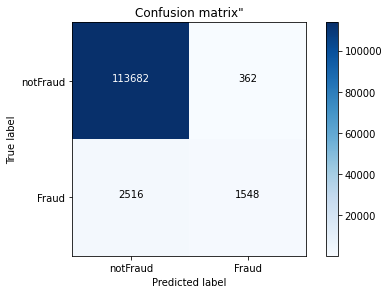

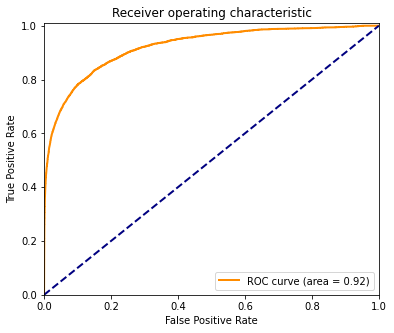

In [14]:
y_pred = test_df_w_pred_lgb['prediction'].apply(lambda x: 1 if x>0.5 else 0).values
fpr, tpr, _ = roc_curve(y_test, test_df_w_pred_lgb['prediction'])

plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['notFraud', 'Fraud'])
plot_roc_auc(fpr,tpr)

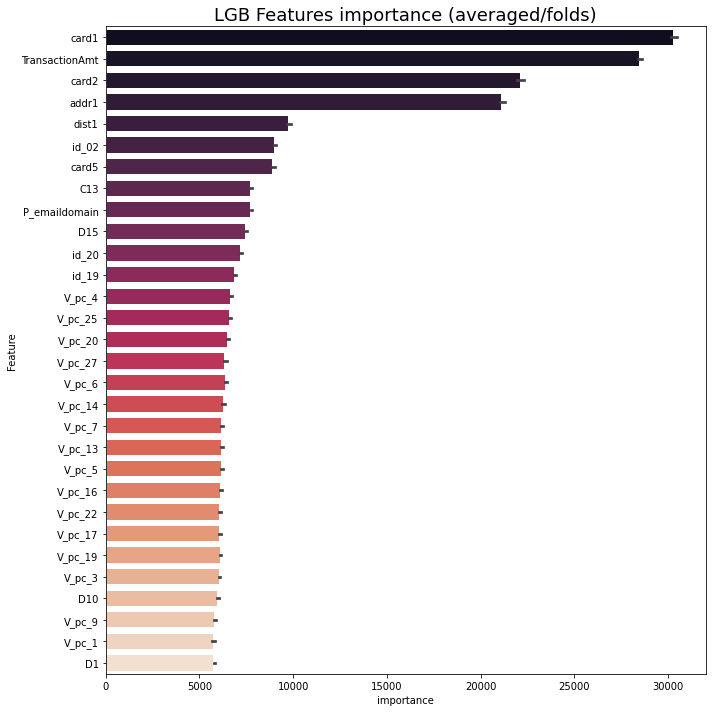

In [15]:
cols = (feat_importance_df_lgb[["Feature", "importance"]]
    .groupby("Feature")
    .mean()
    .sort_values(by="importance", ascending=False)[:30].index)
best_features = feat_importance_df_lgb.loc[feat_importance_df_lgb.Feature.isin(cols)]

plt.figure(figsize=(10,10))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False),
        edgecolor=('white'), linewidth=2, palette="rocket")
plt.title('LGB Features importance (averaged/folds)', fontsize=18)
plt.tight_layout()

# Summary



__What can be inferred__

- learning time, 
  - logistic : ~800s in the tuning process, ~30s in single fit
  - LGBM : ~700s/fold 
- generated weights, rough estimation to get reasons for model size and learning time
  - logistic : num of features+bias ~104
  - LGBM : too complex to count

- Simple model tend to poorly perform. Because of initially the features included were huge so the complexity.
- The fold idea is doing well, mainly because the initial samples were huge.
- LGBM works fine, though the dataset have imbalance in labels and a lot of features, but the model have learning structure and tunable parameters resulting fine performance.

__What can be improved__

- Features:
  - Generate features by aggregating between them (need further exploration both meaning of the features and statistic approach) and see how it impacts the model performance
  - Try to drop less important features.
  - Feature selection like PCA or other methods t-SNE might be able to be applied to the whole dataset.

- Model:
  - LGBM have a lot of parameters. Try and evaluate more parameters to get positive impact on performace, training time, and inference time. Also there is already boosting method to get the best parameters.
  - Should try neural network, since the data already relatively sufficient in number of samples and number of features.

- Other:
  - There are method in sampling to approach imbalance class: over-sampling and under-sampling. The idea is let the model learn better with the same number of samples for each class. Surely there are also the drawbacks.